In [1]:
# XO's note on 02/15/2022: This is a quick check on the distribution of the input kinematic parameters
# and orbital parameters for HDBSCAN after resampling and how much they differ from the mean values

In [2]:
# Import the libraries
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from scipy.interpolate import interpn
import seaborn as sns

cmap = ListedColormap(sns.color_palette("colorblind",256))
pal = sns.color_palette('colorblind', 256)

import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import LSR
coord.galactocentric_frame_defaults.set('v4.0')


label_size = 24
matplotlib.rc('font', size=label_size)

import warnings
warnings.filterwarnings("once")

In [3]:
LSR?

Init signature:
LSR(
    *args,
    copy=True,
    representation_type=None,
    differential_type=None,
    **kwargs,
)
Docstring:     
A coordinate or frame in the Local Standard of Rest (LSR).

This coordinate frame is axis-aligned and co-spatial with `ICRS`, but has
a velocity offset relative to the solar system barycenter to remove the
peculiar motion of the sun relative to the LSR. Roughly, the LSR is the mean
velocity of the stars in the solar neighborhood, but the precise definition
of which depends on the study. As defined in Schönrich et al. (2010):
"The LSR is the rest frame at the location of the Sun of a star that would
be on a circular orbit in the gravitational potential one would obtain by
azimuthally averaging away non-axisymmetric features in the actual Galactic
potential." No such orbit truly exists, but it is still a commonly used
velocity frame.

We use default values from Schönrich et al. (2010) for the barycentric
velocity relative to the LSR, which is defined in

In [4]:
# Import the data
df_vel_all = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')
df_orb_all = pd.read_hdf('../data/dr3_orb_param_err_g2_only.h5')

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
# calculate the columns for the scaled action diamond
df_orb_all['Jtot'] = np.sqrt(df_orb_all['Jphi']**2+df_orb_all['JR']**2+df_orb_all['Jz']**2)
df_orb_all['diamond_x']=df_orb_all['Jphi']/df_orb_all['Jtot']
df_orb_all['diamond_y']=(df_orb_all['Jz']-df_orb_all['JR'])/df_orb_all['Jtot']

# Calculate the error for Jtot and diamond_x/y
df_orb_all['e_Jtot'] = np.sqrt(df_orb_all['Jphi']**2*df_orb_all['e_Jphi']**2+df_orb_all['JR']**2*df_orb_all['e_JR']**2+df_orb_all['Jz']**2*df_orb_all['e_Jz']**2)/df_orb_all['Jtot']
df_orb_all['e_diamond_x']=np.sqrt(df_orb_all['Jtot']**2*df_orb_all['e_Jphi']**2+df_orb_all['e_Jtot']**2*df_orb_all['Jphi']**2)/df_orb_all['Jtot']**2
df_orb_all['e_diamond_y']=np.sqrt(df_orb_all['Jtot']**2*(df_orb_all['e_JR']**2+df_orb_all['e_Jz']**2)+df_orb_all['e_Jtot']**2*(df_orb_all['Jz']-df_orb_all['JR'])**2)/df_orb_all['Jtot']**2

# Calculate L_perp for clustering
df_orb_all['Lperp'] = np.sqrt(df_orb_all['Lx']**2+df_orb_all['Ly']**2)
df_orb_all['e_Lperp'] = np.sqrt(df_orb_all['Lx']**2*df_orb_all['e_Lx']**2+df_orb_all['Ly']**2*df_orb_all['e_Ly']**2)/df_orb_all['Lperp']

In [6]:
print(df_vel_all.columns,df_orb_all.columns)

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2', 'vr_g2', 'vphi_g2',
       'vz_g2', 'vrerr_g2', 'vphierr_g2', 'vzerr_g2', 'vrphicov_g2',
       'vrzcov_g2', 'vphizcov_g2', 'm_h_ap17', 'm_h_err_ap17', 'alpha_m_ap17',
       'alpha_m_err_ap17', 'aspcap_flg_ap17'],
    

In [7]:
# Apply the cuts as I would before clustering
# Define what axes go into PCA
action = False
diamond = False
metallicity = False
velocity = True
cylindrical = True
position = False
energy = False
eccentricity = False
Lz = False
Lperp = False

# Define what axes go into GMM with PCA results
# By default, include whatever was not in PCA
action_add = not action
metallicity_add = not metallicity
velocity_add = not velocity
position_add = not position
energy_add = not energy
eccentricity_add = not eccentricity
Lz_add = not Lz
Lperp_add = not Lperp

# Manual override additional axes
action_add = False
position_add = False
metallicity_add = False
velocity_add = False
energy_add = False
eccentricity_add = False
Lz_add = False
Lperp_add = False

cutoff = 2500
kin_qual = ((abs(df_vel_all['U_g2']) < 1000) & 
            (abs(df_vel_all['V_g2']) < 1000) & (abs(df_vel_all['W_g2']) < 1000) & 
            (df_vel_all['qual_flag'] == 0) # & 
           )

# zmax cut selection
# selection = ((df_orb_all['zmax']-2*df_orb_all['e_zmax']) > cutoff)
# A pure Toomre cut selection just to see if I can reproduce their results
selection = (np.sqrt((df_vel_all['U_g2'])**2+(df_vel_all['V_g2']-232)**2+(df_vel_all['W_g2'])**2) > 210)


# Quickly print the sample size without error cut
combined_cut_pre_err = kin_qual & selection


# Add in an additional relative error cut on the input parameters; ignore it if the value is greater than 99
error_cut = np.copy(kin_qual)
rel_err_cutoff = 0.05
# Set a flag to decide if we want to apply an absolute cut when available
error_cut_rel_flag = False

if rel_err_cutoff < 99:
    if action == True or action_add == True:
        if diamond == True:
            error_cut = error_cut & (abs(df_orb_all['e_diamond_x']/df_orb_all['diamond_x']) < rel_err_cutoff)
            error_cut = error_cut & (abs(df_orb_all['e_diamond_y']/df_orb_all['diamond_y']) < rel_err_cutoff)
        elif diamond == False:
            if error_cut_rel_flag:
                error_cut = error_cut & (abs(df_orb_all['e_JR']/df_orb_all['JR']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_orb_all['e_Jphi']/df_orb_all['Jphi']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_orb_all['e_Jz']/df_orb_all['Jz']) < rel_err_cutoff)
            else:
                error_cut = error_cut & (df_orb_all['e_JR'] < 150)
                error_cut = error_cut & (df_orb_all['e_Jphi'] < 100)
                error_cut = error_cut & (df_orb_all['e_Jz'] < 100)

    if metallicity == True or metallicity_add == True:
        feh_qual = feh_qual & (abs(df_vel_all['e_m_h_mean']/df_vel_all['m_h_mean']) < rel_err_cutoff)

    if velocity == True or velocity_add == True:
        if cylindrical == True:
            if error_cut_rel_flag:
                error_cut = error_cut & (abs(df_vel_all['vrerr_g2']/df_vel_all['vr_g2']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_vel_all['vphierr_g2']/df_vel_all['vphi_g2']) < rel_err_cutoff)
                error_cut = error_cut & (abs(df_vel_all['vzerr_g2']/df_vel_all['vz_g2']) < rel_err_cutoff)
            else:
                error_cut = error_cut & (df_vel_all['vrerr_g2'] < 20)
                error_cut = error_cut & (df_vel_all['vphierr_g2'] < 20)
                error_cut = error_cut & (df_vel_all['vzerr_g2'] < 20)
        elif cylindrical == False:
            error_cut = error_cut & (abs(df_vel_all['Uerr_g2']/df_vel_all['U_g2']) < rel_err_cutoff)
            error_cut = error_cut & (abs(df_vel_all['Verr_g2']/df_vel_all['V_g2']) < rel_err_cutoff)
            error_cut = error_cut & (abs(df_vel_all['Werr_g2']/df_vel_all['W_g2']) < rel_err_cutoff)

    if position == True or position_add == True:
        error_cut = error_cut & (abs(df_vel_all['XGCerr']/df_vel_all['XGC']) < rel_err_cutoff)
        error_cut = error_cut & (abs(df_vel_all['YGCerr']/df_vel_all['YGC']) < rel_err_cutoff)
        error_cut = error_cut & (abs(df_vel_all['ZGCerr']/df_vel_all['ZGC']) < rel_err_cutoff)

    if energy == True or energy_add == True:
        if error_cut_rel_flag:
            error_cut = error_cut & (abs(df_orb_all['e_Etot']/df_orb_all['Etot']) < rel_err_cutoff)
        else:
            error_cut = error_cut & (df_orb_all['e_Etot'] < 4000)

    if eccentricity == True or eccentricity_add == True:
        error_cut = error_cut & (abs(df_orb_all['e_ecc']/df_orb_all['ecc']) < rel_err_cutoff)

    if Lz == True or Lz_add == True:
        if error_cut_rel_flag:
            error_cut = error_cut & (abs(df_orb_all['e_Lz']/df_orb_all['Lz']) < rel_err_cutoff)
        else:
            error_cut = error_cut & (df_orb_all['e_Lz'] < 100)

    if Lperp == True or Lperp_add == True:
        if error_cut_rel_flag:
            error_cut = error_cut & (abs(df_orb_all['e_Lperp']/df_orb_all['Lperp']) < rel_err_cutoff)
        else:
            error_cut = error_cut & (df_orb_all['e_Lperp'] < 100)

# Put all cuts together
combined_cut = kin_qual & selection & error_cut

# Print the sample sizes at different cut
ind_cut_pre_err_zmax = np.where(kin_qual)[0]
print('Sample size with quality cut:',len(ind_cut_pre_err_zmax))

ind_cut_pre_err = np.where(combined_cut_pre_err)[0]
print('Sample size with quality and selection cut:',len(ind_cut_pre_err))

ind_cut = np.where(combined_cut)[0]
if error_cut_rel_flag:
    print('Sample size with quality, selection, and relative error cut:',len(ind_cut))
else:
    print('Sample size with quality, selection, and absolute error cut:',len(ind_cut))


Sample size with quality cut: 5557670
Sample size with quality and selection cut: 54332
Sample size with quality, selection, and absolute error cut: 48783


In [ ]:
# Calculate the velocities U, V, W in LSR frame
# vLSR = []

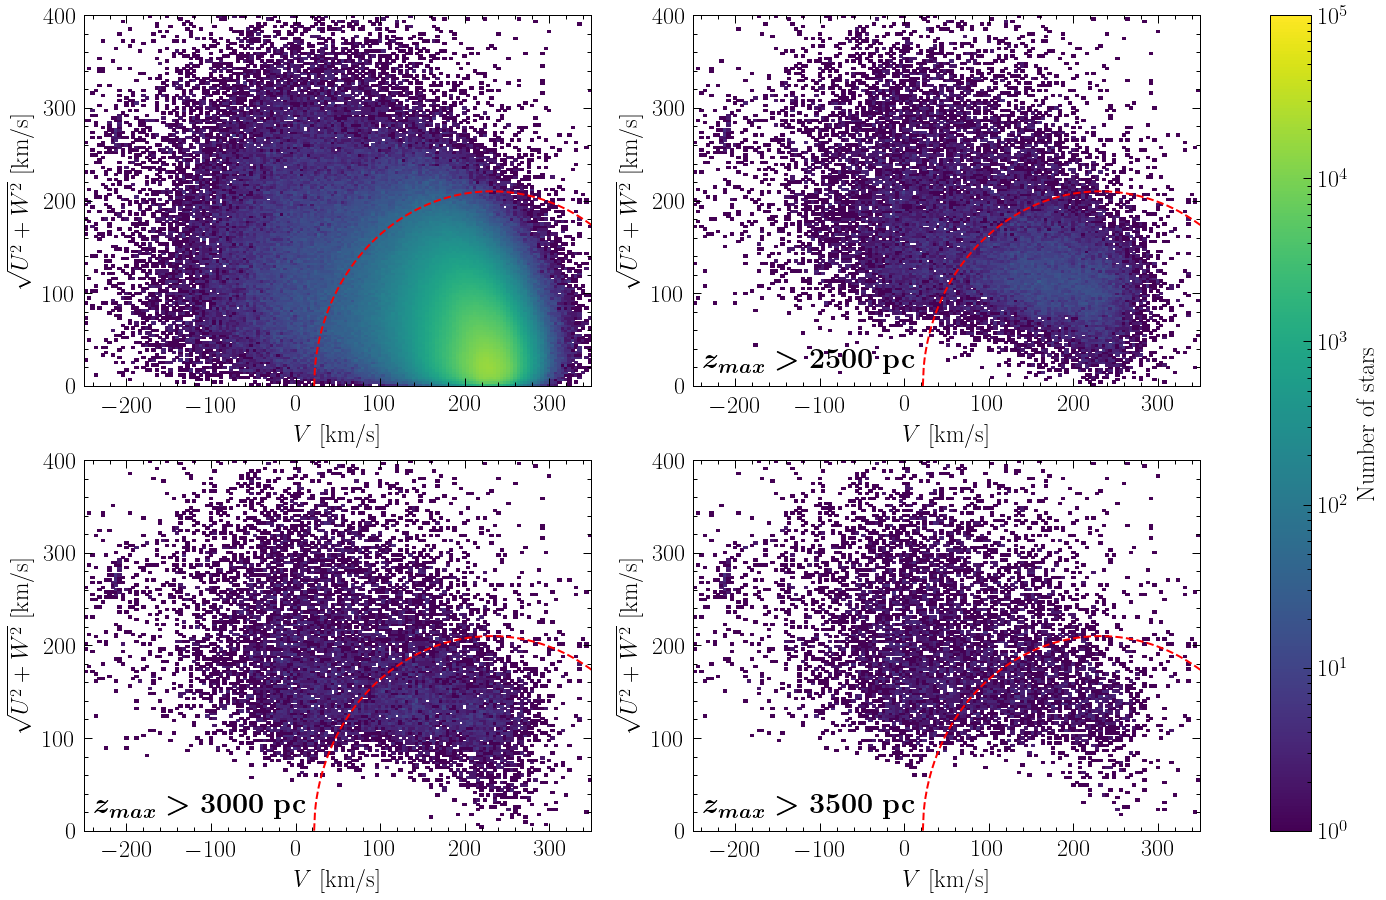

In [13]:
# Plot the full sample in Toomre plot
f = plt.figure(figsize=[25,15])

lognorm_min = 1
lognorm_max = 1e5

LSR_cut = 210
V_LSR = 232
V_arr = np.arange(V_LSR-LSR_cut,V_LSR+LSR_cut,1)
y_arr = np.sqrt(LSR_cut**2-(V_arr-V_LSR)**2)

# Plot all stars that passed the quality cut
i_tmp = ind_cut_pre_err_zmax

ax1 = plt.subplot(2,2,1)
ax1.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-250, 350], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
# plt.colorbar()
ax1.set_xlabel(r'$V$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
ax1.plot(V_arr,y_arr,c='r',ls='--')

# Plot all stars that passed the quality cut and zmax 2.5 kpc cut
cutoff = 2500
selection = ((df_orb_all['zmax']-2*df_orb_all['e_zmax']) > cutoff)
combined_cut_pre_err = kin_qual & selection
i_tmp = np.where(combined_cut_pre_err)[0]

ax2 = plt.subplot(2,2,2)
ax2.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-250, 350], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
# ax2.text(0.02, 0.02, r'$\mathbf{z_{max}>2500}$ \textbf{pc}', horizontalalignment='left',fontsize='large',
#          verticalalignment='bottom', transform=ax2.transAxes)
ax2.text(0.02, 0.02, r'\boldmath$z_{max}>2500$ \textbf{pc}', horizontalalignment='left',fontsize='large',
         verticalalignment='bottom', transform=ax2.transAxes)
# plt.colorbar()
ax2.set_xlabel(r'$V$ [km/s]')
ax2.set_ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
ax2.plot(V_arr,y_arr,c='r',ls='--')

# Plot all stars that passed the quality cut and zmax 3.0 kpc cut
cutoff = 3000
selection = ((df_orb_all['zmax']-2*df_orb_all['e_zmax']) > cutoff)
combined_cut_pre_err = kin_qual & selection
i_tmp = np.where(combined_cut_pre_err)[0]

ax3 = plt.subplot(2,2,3)
ax3.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-250, 350], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
ax3.text(0.02, 0.02, r'\boldmath$z_{max}>3000$ \textbf{pc}', horizontalalignment='left',fontsize='large',
         verticalalignment='bottom', transform=ax3.transAxes)
# plt.colorbar()
ax3.set_xlabel(r'$V$ [km/s]')
ax3.set_ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
ax3.plot(V_arr,y_arr,c='r',ls='--')

# Plot all stars that passed the quality cut and zmax 3.5 kpc cut
cutoff = 3500
selection = ((df_orb_all['zmax']-2*df_orb_all['e_zmax']) > cutoff)
combined_cut_pre_err = kin_qual & selection
i_tmp = np.where(combined_cut_pre_err)[0]

ax4 = plt.subplot(2,2,4)
_, _, _, im = ax4.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-250, 350], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
ax4.text(0.02, 0.02, r'\boldmath$z_{max}>3500$ \textbf{pc}', horizontalalignment='left',fontsize='large',
         verticalalignment='bottom', transform=ax4.transAxes)
# plt.colorbar()
ax4.set_xlabel(r'$V$ [km/s]')
ax4.set_ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
ax4.plot(V_arr,y_arr,c='r',ls='--')

cb = f.colorbar(im, ax=[ax1,ax2,ax3,ax4])

cb.ax.set_ylabel('Number of stars')

# f.tight_layout()
plt.show()
f.savefig("./toomre/toomre_full+3cuts.pdf")

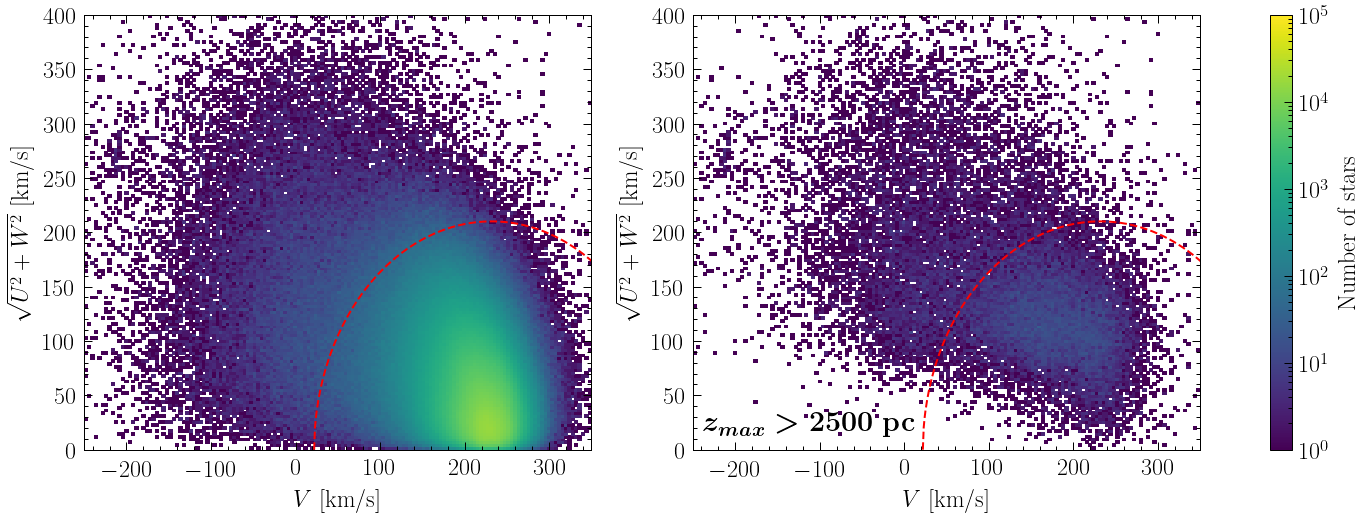

In [12]:
# Plot the full sample in Toomre plot
f = plt.figure(figsize=[25,8])

lognorm_min = 1
lognorm_max = 1e5

LSR_cut = 210
V_LSR = 232
V_arr = np.arange(V_LSR-LSR_cut,V_LSR+LSR_cut,1)
y_arr = np.sqrt(LSR_cut**2-(V_arr-V_LSR)**2)

# Plot all stars that passed the quality cut
i_tmp = ind_cut_pre_err_zmax

ax1 = plt.subplot(1,2,1)
ax1.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-250, 350], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
# plt.colorbar()
ax1.set_xlabel(r'$V$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
ax1.plot(V_arr,y_arr,c='r',ls='--')

# Plot all stars that passed the quality cut and zmax 2.5 kpc cut
cutoff = 2500
selection = ((df_orb_all['zmax']-2*df_orb_all['e_zmax']) > cutoff)
combined_cut_pre_err = kin_qual & selection
i_tmp = np.where(combined_cut_pre_err)[0]

ax2 = plt.subplot(1,2,2)
_, _, _, im = ax2.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-250, 350], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
# ax2.text(0.02, 0.02, r'$\mathbf{z_{max}>2500}$ \textbf{pc}', horizontalalignment='left',fontsize='large',
#          verticalalignment='bottom', transform=ax2.transAxes)
ax2.text(0.02, 0.02, r'\boldmath$z_{max}>2500$ \textbf{pc}', horizontalalignment='left',fontsize='large',
         verticalalignment='bottom', transform=ax2.transAxes)
# plt.colorbar()
ax2.set_xlabel(r'$V$ [km/s]')
ax2.set_ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
ax2.plot(V_arr,y_arr,c='r',ls='--')


cb = f.colorbar(im, ax=[ax1,ax2])

cb.ax.set_ylabel('Number of stars')

# f.tight_layout()
plt.show()
f.savefig("./toomre/toomre_full+1cuts.pdf")

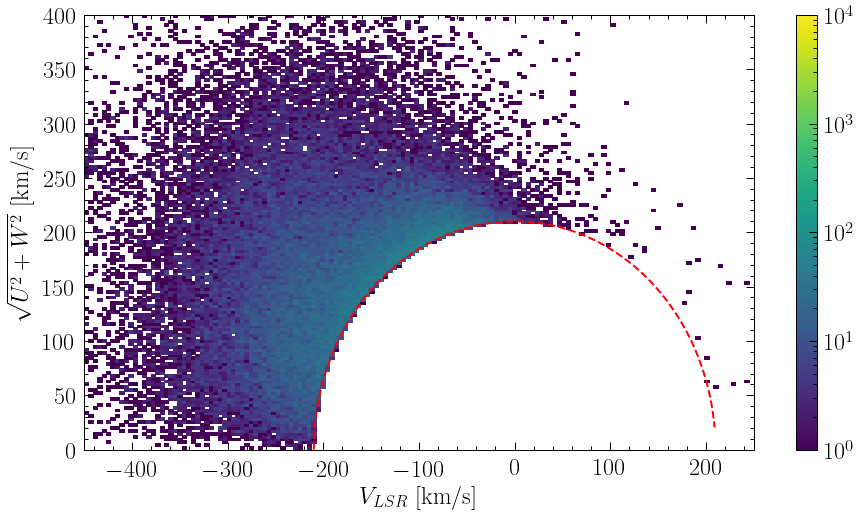

In [23]:
# Plot the full sample in Toomre plot
f = plt.figure(figsize=[15,8])

lognorm_min = 1
lognorm_max = 1e4

LSR_cut = 210
V_LSR = 232
V_arr = np.arange(V_LSR-LSR_cut,V_LSR+LSR_cut,1)-V_LSR
y_arr = np.sqrt(LSR_cut**2-(V_arr)**2)

# Plot all stars that passed the quality cut
i_tmp = ind_cut_pre_err


plt.hist2d(df_vel_all.loc[i_tmp,'V_g2'].values-V_LSR,np.sqrt(df_vel_all.loc[i_tmp,'U_g2'].values**2+df_vel_all.loc[i_tmp,'W_g2'].values**2),\
           range=[[-450, 250], [0, 400]],bins=150,norm=LogNorm(vmin=lognorm_min,vmax=lognorm_max))
plt.colorbar()
plt.xlabel(r'$V_{LSR}$ [km/s]')
plt.ylabel(r'$\sqrt{U^2+W^2}$ [km/s]')

# Draw the LSR cuts
plt.plot(V_arr,y_arr,c='r',ls='--')

plt.show()
f.savefig("./toomre/toomre_cut.pdf")

# of stars out of the whole sample with valid JR value is 6055498


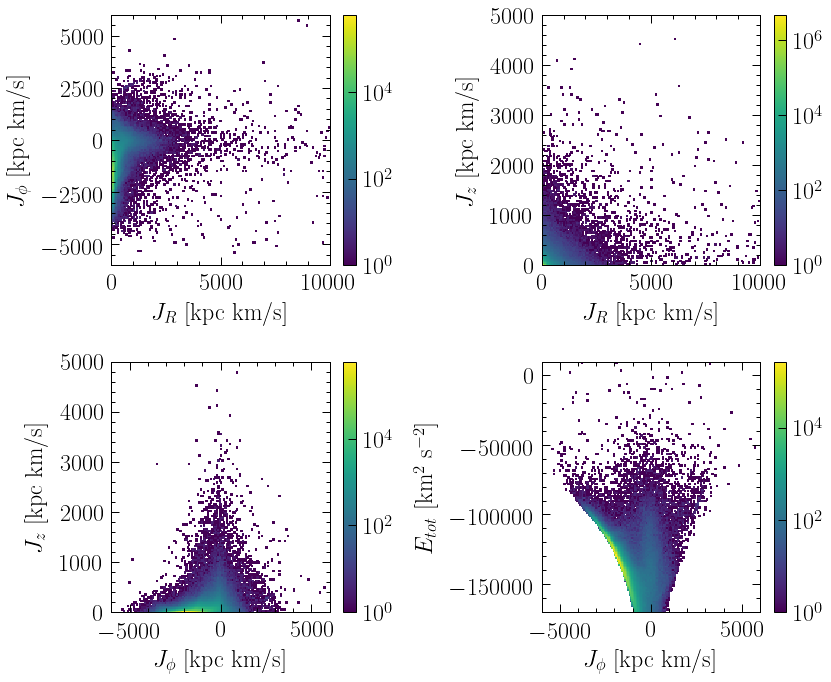

In [34]:
# Plot the full sample in Action+E space
f = plt.figure(figsize=[12,10])

id_tmp = np.where(np.isnan(df_orb_all['JR']) == False)[0]
print('# of stars out of the whole sample with valid JR value is',len(id_tmp))

ax1 = plt.subplot(2,2,1)
plt.hist2d(df_orb_all.loc[id_tmp,'JR'].values,df_orb_all.loc[id_tmp,'Jphi'].values,\
           range=[[0, 10000], [-6000, 6000]],bins=150,norm=LogNorm())
plt.colorbar()
ax1.set_xlabel(r'$J_R$ [kpc km/s]')
ax1.set_ylabel(r'$J_{\phi}$ [kpc km/s]')

ax2 = plt.subplot(2,2,2)
plt.hist2d(df_orb_all.loc[id_tmp,'JR'].values,df_orb_all.loc[id_tmp,'Jz'].values,\
           range=[[0, 10000], [0, 5000]],bins=150,norm=LogNorm())
plt.colorbar()
ax2.set_xlabel(r'$J_R$ [kpc km/s]')
ax2.set_ylabel(r'$J_z$ [kpc km/s]')

ax3 = plt.subplot(2,2,3)
plt.hist2d(df_orb_all.loc[id_tmp,'Jphi'].values,df_orb_all.loc[id_tmp,'Jz'].values,\
           range=[[-6000, 6000], [0, 5000]],bins=150,norm=LogNorm())
plt.colorbar()
ax3.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax3.set_ylabel(r'$J_z$ [kpc km/s]')

ax4 = plt.subplot(2,2,4)
plt.hist2d(df_orb_all.loc[id_tmp,'Jphi'].values,df_orb_all.loc[id_tmp,'Etot'].values,\
           range=[[-6000, 6000], [-170000, 10000]],bins=150,norm=LogNorm())
plt.colorbar()
ax4.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax4.set_ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')

f.tight_layout()
plt.show()

f.savefig("./random_distribution/full_sample.pdf")

# of stars out of the whole sample passed quality cut is 5557670


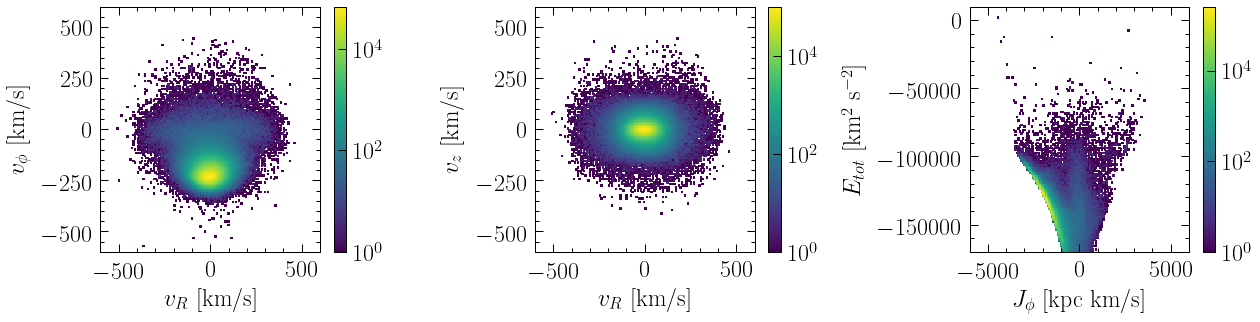

In [11]:
# Plot the sample that passed quality cut in E-Lz vphi-vr and vz-vr space
f = plt.figure(figsize=[18,5])

id_tmp = ind_cut_pre_err_zmax
print('# of stars out of the whole sample passed quality cut is',len(id_tmp))

ax1 = plt.subplot(1,3,1)
plt.hist2d(df_vel_all.loc[id_tmp,'vr_g2'].values,df_vel_all.loc[id_tmp,'vphi_g2'].values,\
           range=[[-600, 600], [-600, 600]],bins=150,norm=LogNorm())
plt.colorbar()
ax1.set_xlabel(r'$v_R$ [km/s]')
ax1.set_ylabel(r'$v_{\phi}$ [km/s]')

ax2 = plt.subplot(1,3,2)
plt.hist2d(df_vel_all.loc[id_tmp,'vr_g2'].values,df_vel_all.loc[id_tmp,'vz_g2'].values,\
           range=[[-600, 600], [-600, 600]],bins=150,norm=LogNorm())
plt.colorbar()
ax2.set_xlabel(r'$v_R$ [km/s]')
ax2.set_ylabel(r'$v_z$ [km/s]')

ax3 = plt.subplot(1,3,3)
plt.hist2d(df_orb_all.loc[id_tmp,'Jphi'].values,df_orb_all.loc[id_tmp,'Etot'].values,\
           range=[[-6000, 6000], [-170000, 10000]],bins=150,norm=LogNorm())
plt.colorbar()
ax3.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax3.set_ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')

f.tight_layout()
plt.show()

f.savefig("./random_distribution/selected_sample_v_E_Lz.pdf")

In [33]:
# Resample the space as I did with random realization
ms = 1
al = 0.2
mc = 'k'

path_tmp = 'random_distribution/vel_2500_cut_rand_gif_v_E_Lz/rand_realization_'
# Sample the ydata before feeding into scaler and the clustering algorithm
np.random.seed(42)

# Generate a random list of seed from the single seed specified above
N_samp = 100
rand_seed_list = np.random.choice(np.arange(10000,dtype=int),N_samp,replace=False)

for i in range(N_samp):
    np.random.seed(rand_seed_list[i])

    ydata_ini = []
    ydata_ini_err = []

    ydata_ini.append(df_vel_all.loc[ind_cut,'vr_g2'])
    ydata_ini.append(df_vel_all.loc[ind_cut,'vphi_g2'])
    ydata_ini.append(df_vel_all.loc[ind_cut,'vz_g2'])
    ydata_ini.append(df_orb_all.loc[ind_cut,'Jphi'])
    ydata_ini.append(df_orb_all.loc[ind_cut,'Etot'])
    ydata_ini_err.append(df_vel_all.loc[ind_cut,'vrerr_g2'])
    ydata_ini_err.append(df_vel_all.loc[ind_cut,'vphierr_g2'])
    ydata_ini_err.append(df_vel_all.loc[ind_cut,'vzerr_g2'])
    ydata_ini_err.append(df_orb_all.loc[ind_cut,'e_Jphi'])
    ydata_ini_err.append(df_orb_all.loc[ind_cut,'e_Etot'])

    ydata = np.array(ydata_ini).T
    ydata_err = np.array(ydata_ini_err).T

    ydata_samp = np.zeros(np.shape(ydata))
    for j in range(len(ydata_samp[0,:])):
        ydata_samp[:,j] = np.random.normal(ydata[:,j], ydata_err[:,j])
        
    # Plot the selected sample in vel and E-Lz space but resampled
    f = plt.figure(figsize=[16,5])
    
    ax1 = plt.subplot(1,3,1)
    plt.scatter(ydata_samp[:,0],ydata_samp[:,1],s=ms,c=mc,alpha=al)
    ax1.set_xlabel(r'$v_R$ [km/s]')
    ax1.set_ylabel(r'$v_{\phi}$ [km/s]')
    ax1.set_xlim([-600,600])
    ax1.set_ylim([-600,600])

    ax2 = plt.subplot(1,3,2)
    plt.scatter(ydata_samp[:,0],ydata_samp[:,2],s=ms,c=mc,alpha=al)
    ax2.set_xlabel(r'$v_R$ [km/s]')
    ax2.set_ylabel(r'$v_z$ [km/s]')
    ax2.set_xlim([-600,600])
    ax2.set_ylim([-600,600])
    
    ax3 = plt.subplot(1,3,3)
    plt.scatter(ydata_samp[:,3],ydata_samp[:,4],s=ms,c=mc,alpha=al)
    ax3.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
    ax3.set_ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')
    ax3.set_xlim([-6000, 6000])
    ax3.set_ylim([-180000, 0])
    
    f.tight_layout()
#     plt.show()
    
    f.savefig(path_tmp+'scatter_'+str(i)+'.png')
    plt.close()
    
    # Plot the selected sample in vel and E-Lz space with hist2d but resampled
    f = plt.figure(figsize=[18,5])
    
    ax1 = plt.subplot(1,3,1)
    plt.hist2d(ydata_samp[:,0],ydata_samp[:,1],range=[[-600, 600], [-600, 600]],bins=150,norm=LogNorm())
    plt.colorbar()
    ax1.set_xlabel(r'$v_R$ [km/s]')
    ax1.set_ylabel(r'$v_{\phi}$ [km/s]')
    ax1.set_xlim([-600,600])
    ax1.set_ylim([-600,600])

    ax2 = plt.subplot(1,3,2)
    plt.hist2d(ydata_samp[:,0],ydata_samp[:,2],range=[[-600, 600], [-600, 600]],bins=150,norm=LogNorm())
    plt.colorbar()
    ax2.set_xlabel(r'$v_R$ [km/s]')
    ax2.set_ylabel(r'$v_z$ [km/s]')
    ax2.set_xlim([-600,600])
    ax2.set_ylim([-600,600])
    
    ax3 = plt.subplot(1,3,3)
    plt.hist2d(ydata_samp[:,3],ydata_samp[:,4],range=[[-6000, 6000], [-180000, 0]],bins=150,norm=LogNorm())
    plt.colorbar()
    ax3.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
    ax3.set_ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')
    ax3.set_xlim([-6000, 6000])
    ax3.set_ylim([-180000, 0])

    f.tight_layout()
#     plt.show()
    
    f.savefig(path_tmp+'hist2d_'+str(i)+'.png')
    plt.close()

In [34]:
# Create the gif from the created frames
import imageio
images = []
filenames = []
for i in range(N_samp):
    try:
        filenames.append(path_tmp+'scatter_'+str(i)+'.png')
    except:
        continue
# print(filenames)

for filename in filenames:
    try:
        images.append(imageio.imread(filename))
    except:
        continue
    
imageio.mimsave(path_tmp+'scatter.gif', images)

images = []
filenames = []
for i in range(N_samp):
    try:
        filenames.append(path_tmp+'hist2d_'+str(i)+'.png')
    except:
        continue
# print(filenames)

for filename in filenames:
    try:
        images.append(imageio.imread(filename))
    except:
        continue
    
imageio.mimsave(path_tmp+'hist2d.gif', images)

# of stars after zmax+error+qual cut 25298


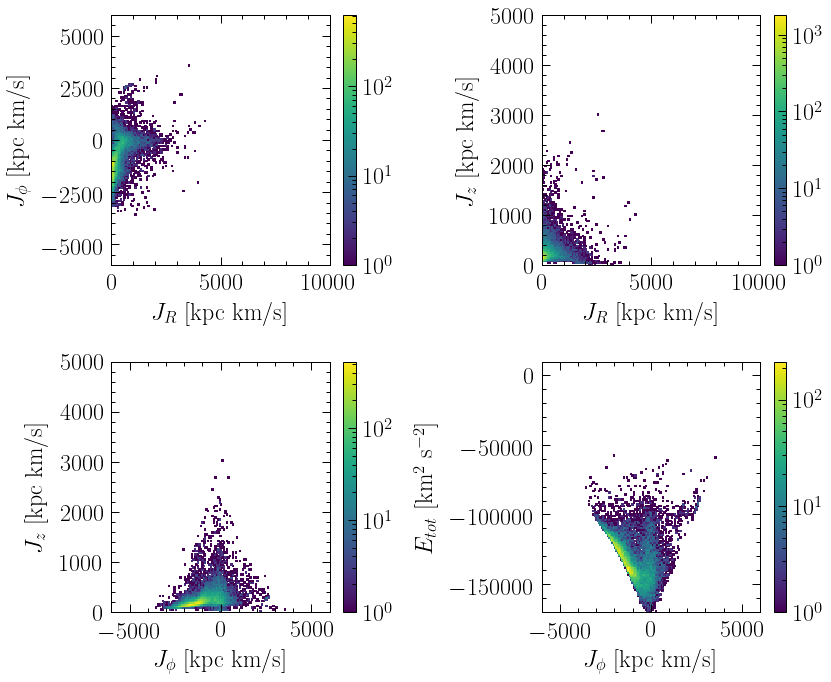

In [35]:
# Plot the selected sample in Action+E space
f = plt.figure(figsize=[12,10])

id_tmp = ind_cut
print('# of stars after zmax+error+qual cut',len(id_tmp))

ax1 = plt.subplot(2,2,1)
plt.hist2d(df_orb_all.loc[id_tmp,'JR'].values,df_orb_all.loc[id_tmp,'Jphi'].values,\
           range=[[0, 10000], [-6000, 6000]],bins=150,norm=LogNorm())
plt.colorbar()
ax1.set_xlabel(r'$J_R$ [kpc km/s]')
ax1.set_ylabel(r'$J_{\phi}$ [kpc km/s]')

ax2 = plt.subplot(2,2,2)
plt.hist2d(df_orb_all.loc[id_tmp,'JR'].values,df_orb_all.loc[id_tmp,'Jz'].values,\
           range=[[0, 10000], [0, 5000]],bins=150,norm=LogNorm())
plt.colorbar()
ax2.set_xlabel(r'$J_R$ [kpc km/s]')
ax2.set_ylabel(r'$J_z$ [kpc km/s]')

ax3 = plt.subplot(2,2,3)
plt.hist2d(df_orb_all.loc[id_tmp,'Jphi'].values,df_orb_all.loc[id_tmp,'Jz'].values,\
           range=[[-6000, 6000], [0, 5000]],bins=150,norm=LogNorm())
plt.colorbar()
ax3.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax3.set_ylabel(r'$J_z$ [kpc km/s]')

ax4 = plt.subplot(2,2,4)
plt.hist2d(df_orb_all.loc[id_tmp,'Jphi'].values,df_orb_all.loc[id_tmp,'Etot'].values,\
           range=[[-6000, 6000], [-170000, 10000]],bins=150,norm=LogNorm())
plt.colorbar()
ax4.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax4.set_ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')

f.tight_layout()
plt.show()

f.savefig("./random_distribution/zmax_2500_qual_abserr_cut_sample.pdf")

In [32]:
# Resample the actions+E
# Sample the ydata before feeding into scaler and the clustering algorithm
np.random.seed(42)

# Generate a random list of seed from the single seed specified above
N_samp = 100
rand_seed_list = np.random.choice(np.arange(10000,dtype=int),N_samp,replace=False)

np.random.seed(rand_seed_list[0])

ydata_ini = []
ydata_ini_err = []

ydata_ini.append(df_orb_all.loc[ind_cut,'JR'])
ydata_ini.append(df_orb_all.loc[ind_cut,'Jphi'])
ydata_ini.append(df_orb_all.loc[ind_cut,'Jz'])
ydata_ini.append(df_orb_all.loc[ind_cut,'Etot'])
ydata_ini_err.append(df_orb_all.loc[ind_cut,'e_JR'])
ydata_ini_err.append(df_orb_all.loc[ind_cut,'e_Jphi'])
ydata_ini_err.append(df_orb_all.loc[ind_cut,'e_Jz'])
ydata_ini_err.append(df_orb_all.loc[ind_cut,'e_Etot'])

ydata = np.array(ydata_ini).T
ydata_err = np.array(ydata_ini_err).T

ydata_samp = np.zeros(np.shape(ydata))
for j in range(len(ydata_samp[0,:])):
    ydata_samp[:,j] = np.random.normal(ydata[:,j], ydata_err[:,j])

# of resampled stars after zmax+error+qual cut 25298


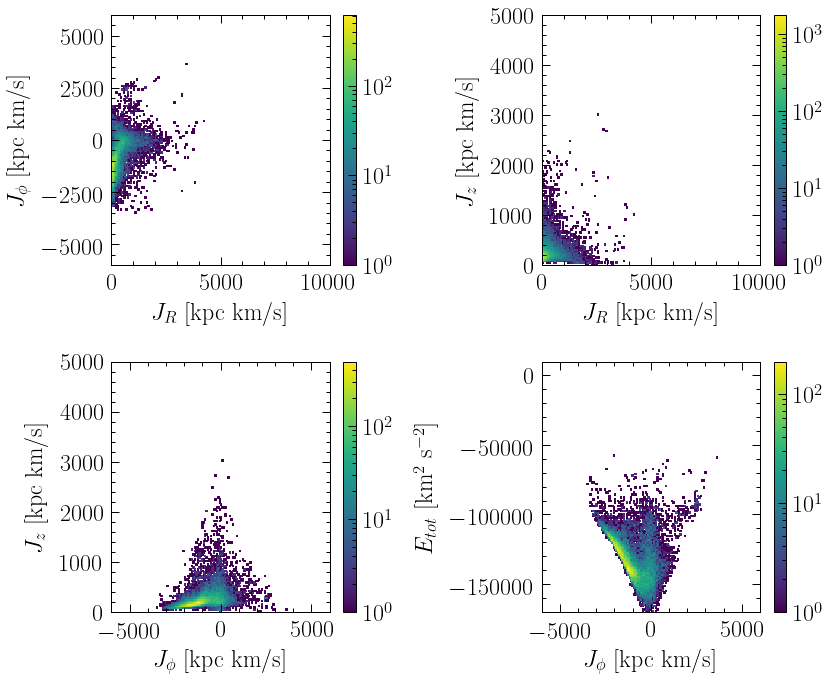

In [36]:
# Plot the selected sample in Action space but resampled
f = plt.figure(figsize=[12,10])

id_tmp = ind_cut
print('# of resampled stars after zmax+error+qual cut',len(id_tmp))

ax1 = plt.subplot(2,2,1)
plt.hist2d(ydata_samp[:,0],ydata_samp[:,1],\
           range=[[0, 10000], [-6000, 6000]],bins=150,norm=LogNorm())
plt.colorbar()
ax1.set_xlabel(r'$J_R$ [kpc km/s]')
ax1.set_ylabel(r'$J_{\phi}$ [kpc km/s]')

ax2 = plt.subplot(2,2,2)
plt.hist2d(ydata_samp[:,0],ydata_samp[:,2],\
           range=[[0, 10000], [0, 5000]],bins=150,norm=LogNorm())
plt.colorbar()
ax2.set_xlabel(r'$J_R$ [kpc km/s]')
ax2.set_ylabel(r'$J_z$ [kpc km/s]')

ax3 = plt.subplot(2,2,3)
plt.hist2d(ydata_samp[:,1],ydata_samp[:,2],\
           range=[[-6000, 6000], [0, 5000]],bins=150,norm=LogNorm())
plt.colorbar()
ax3.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax3.set_ylabel(r'$J_z$ [kpc km/s]')

ax4 = plt.subplot(2,2,4)
plt.hist2d(ydata_samp[:,1],ydata_samp[:,3],\
           range=[[-6000, 6000], [-170000, 10000]],bins=150,norm=LogNorm())
plt.colorbar()
ax4.set_xlabel(r'$J_{\phi}$ [kpc km/s]')
ax4.set_ylabel(r'$E_{tot}$ [km$^2$ s$^{-2}$]')

f.tight_layout()
plt.show()

f.savefig("./random_distribution/zmax_2500_qual_abserr_cut_sample_random.pdf")